# import packages

In [2]:
library(DESeq2)
library(data.table)
library(dplyr)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(EnsDb.Hsapiens.v75)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(IRdisplay)
library(ChIPpeakAnno)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(Seurat)
library(kableExtra)
library(tidyverse)
library(readxl)
library(umap)
library(ggrepel)
library(msigdbr)
library(fgsea)
library(ggvenn)
library(ComplexHeatmap)
library(ggVennDiagram)
library(venneuler)
library(sva)
library(DT)
library(tools)
library(maSigPro)

library(edgeR)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene


In [3]:
source('~/script/utils.r')
setwd('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan//')


In [4]:
cell_types = c('HSC', 'MPP', 'CMP', 'GMP', 'MEP', 'CLP', 'EB', 'MK')

In [5]:
sample_names = c('HSC1', 'HSC2', 'HSC3', 'MPP1', 'MPP2', 'MPP3', 'CMP1', 'CMP2', 
                 'CMP3', 'GMP1', 'GMP2', 'GMP3', 'MEP1', 'MEP2', 'MEP3', 'MEP4', 'CLP1', 'CLP2', 'CLP3', 'EB1', 
                 'EB2', 'EB3', 'MK1', 'MK2', 'MK3')


In [6]:
# these two files from Farhan
dsn = fread('data/EGAD00001000745_RNASeq_of_progenitor_cells_run_files.tsv')

# S00UA1 sample has two bam files of MK cells, 
dsn = dsn[SAMPLE_DESC_2 != 'S00UA1', ]
dsn = dsn[!duplicated(FILE), ]


# data import

In [10]:
mtx_all_df = readRDS('data/mtx_all_df.rds')
dsn_all_df = readRDS('data/dsn_all_df.rds')

dsn_all = as.data.table(dsn_all_df, keep.rownames = T)


In [7]:
dge_all      = readRDS('data/dge_all_may1.rds')
fit_all      = readRDS('data/fit_all_may1.rds')
logcpm_all_t = readRDS('data/logcpm_all_t_may1.rds') 
logcpm_all   = readRDS('data/logcpm_all_may1.rds') 


In [77]:
dge_coding      = readRDS('data/dge_coding_may1.rds') 
fit_coding      = readRDS('data/fit_coding_may1.rds') 
deg_coding_dt   = readRDS('data/fit_coding_may1.rds') 
logcpm_coding_t = readRDS('data/logcpm_coding_t_may1.rds') 
logcpm_coding   = readRDS('data/logcpm_coding_may1.rds') 


In [9]:
dge_te      = readRDS('data/dge_te_may1.rds')
fit_te      = readRDS('data/fit_te_may1.rds')
deg_te_dt   = readRDS('data/fit_te_may1.rds')
logcpm_te_t = readRDS('data/logcpm_te_t_may1.rds')
logcpm_te   = readRDS('data/logcpm_te_may1.rds')


In [42]:
coding_genes = read.table('coding_gene_list', header = F)$V1
te_genes = read.table('te_gene_list', header = F)$V1

mtx_coding_df = mtx_all_df[coding_genes, ]
mtx_te_df = mtx_all_df[!rownames(mtx_all_df) %in% coding_genes, ]


## organize coding and TE genes

In [7]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"


In [ ]:
# TE gene list:
! cat /research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf \ 
| sed 's/.*family_id "//' | sed 's/".*//' |sort -u > te_gene_list 
# coding gene list:
! cat /research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf | sed 's/.*gene_id "//' | sed 's/".*//' |sort -u > coding_gene_list 


In [8]:
coding_genes = read.table('coding_gene_list', header = F)$V1
te_genes = read.table('te_gene_list', header = F)$V1


In [9]:
nrow(mtx_all_df)

[1] 58824

In [10]:
mtx_coding_df = mtx_all_df[coding_genes, ]
mtx_te_df = mtx_all_df[!rownames(mtx_all_df) %in% coding_genes, ]


In [ ]:
# take all together for logcpm
subtype = factor(dsn_all_df$cell_type)
subtype = relevel(subtype, ref = 'HSC')

dge_all = DGEList(counts=mtx_all_df, group = subtype)
dge_all <- calcNormFactors(dge_all)

keep = filterByExpr(dge_all)
dge_all = dge_all[keep, , keep.lib.sizes=FALSE]
dge_all = normLibSizes(dge_all)
design = model.matrix( ~  subtype)
dge_all = estimateDisp(dge_all, design)
fit_all = glmQLFit(dge_all, design, robust = T)

logcpm_all = log1p(cpm(dge_all, normalize = T))
logcpm_all_t = merge(as.data.table(t(logcpm_all), keep.rownames = T), dsn_all, by.x = 'rn', by.y = 'sample_name', all.x = T)
head(logcpm_all_t)



In [96]:
saveRDS(dge_all, file = 'data/dge_all_may1.rds')
saveRDS(fit_all, file = 'data/fit_all_may1.rds')
saveRDS(logcpm_all_t, file = 'data/logcpm_all_t_may1.rds')
saveRDS(logcpm_all, file = 'data/logcpm_all_may1.rds')


## coding gene DEG

In [18]:
subtype = factor(dsn_all_df$cell_type)
subtype = relevel(subtype, ref = 'HSC')

dge_coding = DGEList(counts=mtx_coding_df, group = subtype)
dge_coding <- calcNormFactors(dge_coding)

keep = filterByExpr(dge_coding)
dge_coding = dge_coding[keep, , keep.lib.sizes=FALSE]
dge_coding = normLibSizes(dge_coding)
design = model.matrix( ~  subtype)
dge_coding = estimateDisp(dge_coding, design)
fit_coding = glmQLFit(dge_coding, design, robust = T)


In [ ]:
logcpm_coding = log1p(cpm(dge_coding, normalize = T))
logcpm_coding_t = merge(as.data.table(t(logcpm_coding), keep.rownames = T), dsn_all, by.x = 'rn', by.y = 'sample_name', all.x = T)
head(logcpm_coding_t)


In [ ]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
ggplot(logcpm_coding_t, aes(cell_type, OR11K2P)) + geom_boxplot() + theme_pubr()


In [ ]:
deg_coding_list = lapply(cell_types, function(cc){
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    dge = DGEList(counts=mtx_coding_df, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})



In [ ]:
names(deg_coding_list) = cell_types
deg_coding_dt = rbindlist(deg_coding_list, idcol = T)
head(deg_coding_dt)


In [114]:
saveRDS(dge_coding, file = 'data/dge_coding_may1.rds')
saveRDS(fit_coding, file = 'data/fit_coding_may1.rds')
saveRDS(deg_coding_dt, file = 'data/fit_coding_may1.rds')
saveRDS(logcpm_coding_t, file = 'data/logcpm_coding_t_may1.rds')
saveRDS(logcpm_coding, file = 'data/logcpm_coding_may1.rds')


In [14]:
dge_coding      = readRDS('data/dge_coding_may1.rds') 
fit_coding      = readRDS('data/fit_coding_may1.rds') 
deg_coding_dt   = readRDS('data/fit_coding_may1.rds') 
logcpm_coding_t = readRDS('data/logcpm_coding_t_may1.rds') 
logcpm_coding   = readRDS('data/logcpm_coding_may1.rds') 


## TE gene DEG


In [12]:
subtype = factor(dsn_all_df$cell_type)
subtype = relevel(subtype, ref = 'HSC')

dge_te = DGEList(counts=mtx_te_df, group = subtype)
dge_te <- calcNormFactors(dge_te)

keep = filterByExpr(dge_te)
dge_te = dge_te[keep, , keep.lib.sizes=FALSE]
dge_te = normLibSizes(dge_te)
design = model.matrix( ~  subtype)
dge_te = estimateDisp(dge_te, design)
fit_te = glmQLFit(dge_te, design, robust = T)


In [ ]:
logcpm_te = log1p(cpm(dge_te, normalize = T))
logcpm_te_t = merge(as.data.table(t(logcpm_te), keep.rownames = T), dsn_all, by.x = 'rn', by.y = 'sample_name', all.x = T)
head(logcpm_te_t)


In [14]:
deg_te_list = lapply(cell_types, function(cc){
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    dge = DGEList(counts=mtx_te_df, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})



In [15]:
names(deg_te_list) = cell_types
deg_te_dt = rbindlist(deg_te_list, idcol = T)
head(deg_te_dt)


.id,rn,logFC,logCPM,PValue,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HSC,LTR28C:ERV1:LTR,2.752677,6.486922,1.827448e-09,2.320858e-06
HSC,EUTREP16:LTR:LTR,2.168245,5.857023,3.668335e-07,2.329393e-04
HSC,MER45R:hAT-Tip100:DNA,2.719814,6.380868,6.223043e-07,2.634421e-04
HSC,MER11B:ERVK:LTR,2.857181,5.773299,3.118558e-06,9.901420e-04
HSC,L1ME3Cz:L1:LINE,1.112515,11.985298,7.606676e-06,1.932096e-03
HSC,MER91B:hAT-Tip100:DNA,1.489138,7.039102,1.181644e-05,2.501146e-03


In [119]:
saveRDS(dge_te, file = 'data/dge_te_may1.rds')
saveRDS(fit_te, file = 'data/fit_te_may1.rds')
saveRDS(deg_te_dt, file = 'data/fit_te_may1.rds')
saveRDS(logcpm_te_t, file = 'data/logcpm_te_t_may1.rds')
saveRDS(logcpm_te, file = 'data/logcpm_te_may1.rds')


In [15]:
dge_te      = readRDS('data/dge_te_may1.rds')
fit_te      = readRDS('data/fit_te_may1.rds')
deg_te_dt   = readRDS('data/fit_te_may1.rds')
logcpm_te_t = readRDS('data/logcpm_te_t_may1.rds')
logcpm_te   = readRDS('data/logcpm_te_may1.rds')


## heatmap

### based on the gene list from the paper

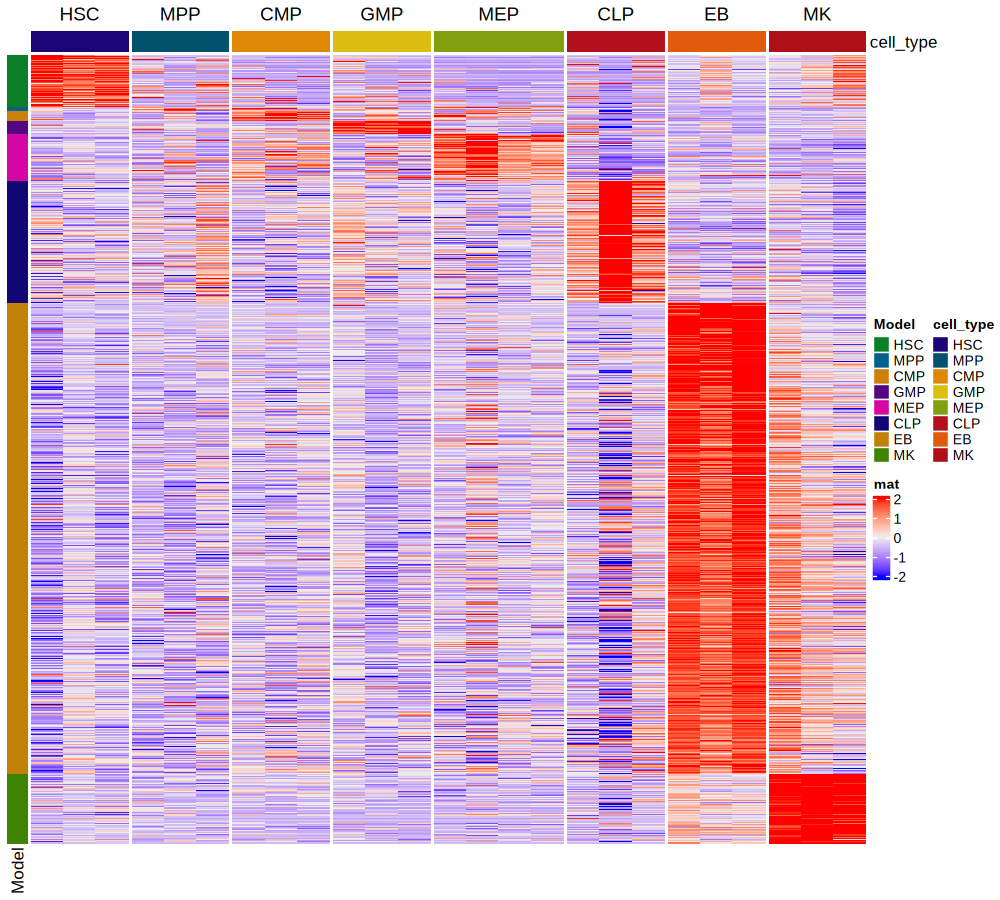

In [27]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

# the gene list from the blueprint paper 
# https://www.science.org/doi/10.1126/scitranslmed.aaz2253
st_4 = as.data.table(read_xlsx('1251033s.xlsx', sheet = 4, skip = 1)  )
setnames(st_4, 9, 'pval')
sig_genes = st_4$External_gene_id
sig_genes = intersect(sig_genes, rownames(logcpm_coding))

st_4_sel = st_4[External_gene_id %in% sig_genes, ]
st_4_sel[, ctype_gene := paste0(Model, '_', External_gene_id)]
st_4_sel[, Model := factor(Model, levels = cell_types)]
st_4_sel = st_4_sel[order(Model), ]

plotdat = logcpm_coding[st_4_sel$External_gene_id, rownames(dsn_all_df)]
rownames(plotdat) = st_4_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = st_4_sel[, .(Model)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,  
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


In [28]:
st_4 = as.data.table(read_xlsx('1251033s.xlsx', sheet = 4, skip = 1)  )
setnames(st_4, 9, 'pval')
st_4_sel = st_4 %>% group_by(Model) %>% slice_max(order_by = pval, n = 20)
dim(st_4_sel)
head(st_4_sel)


[1] 145   9

Model,Ensembl_gene_id,Gene_biotype,External_gene_id,Description,Model posterior probability,log(FC),Second model,pval
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
CLP,ENSG00000250988,processed_transcript,RP11-752G15.6,NA,0.5165430,0.705311,ZERO,0.3931073
CLP,ENSG00000114021,protein_coding,NIT2,"nitrilase family, member 2 [Source:HGNC Symbol;Acc:29878]",0.5314475,0.719120,ZERO,0.3834398
CLP,ENSG00000023697,protein_coding,DERA,deoxyribose-phosphate aldolase (putative) [Source:HGNC Symbol;Acc:24269],0.5023384,0.768791,ZERO,0.3658858
CLP,ENSG00000237973,pseudogene,hsa-mir-6723,hsa-mir-6723 [Source:miRBase;Acc:MI0022558],0.5234394,0.784868,ZERO,0.3345916
CLP,ENSG00000136770,protein_coding,DNAJC1,"DnaJ (Hsp40) homolog, subfamily C, member 1 [Source:HGNC Symbol;Acc:20090]",0.5483222,0.863747,ZERO,0.3281868
CLP,ENSG00000184068,lincRNA,RP5-821D11.7,NA,0.5566616,0.811707,ZERO,0.3254546


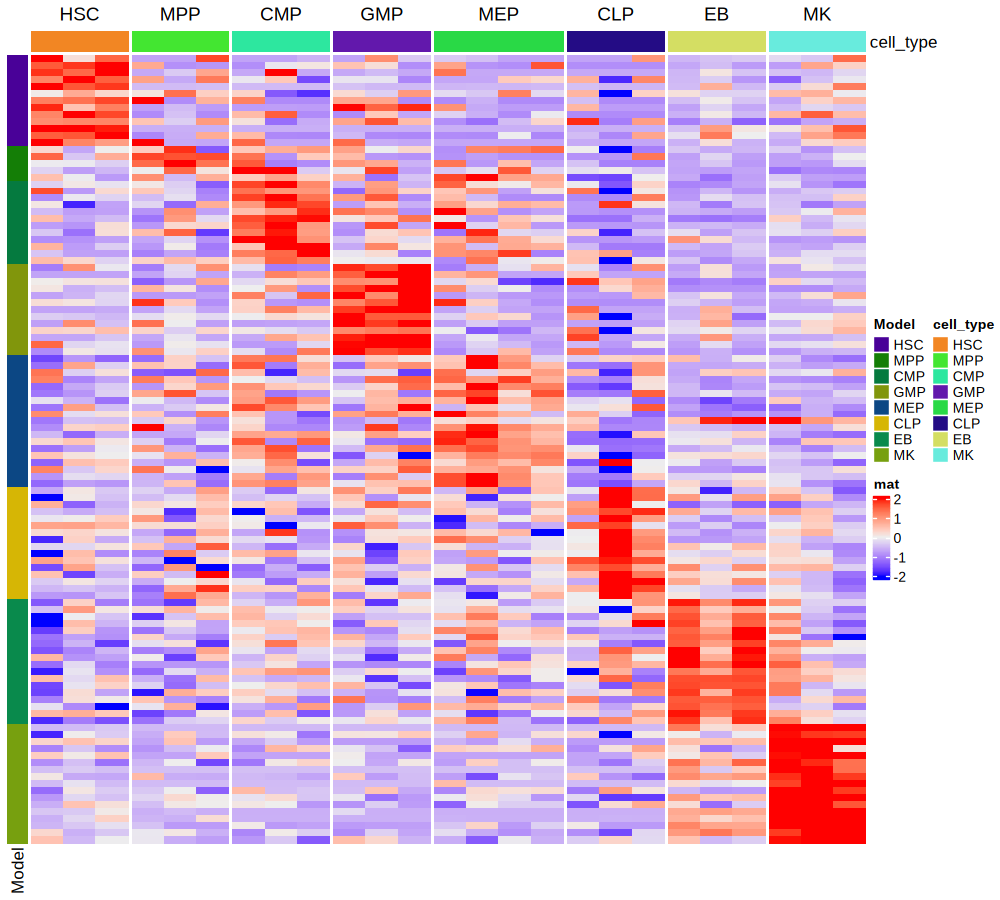

In [29]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

st_4 = as.data.table(read_xlsx('1251033s.xlsx', sheet = 4, skip = 1)  )
setnames(st_4, 9, 'pval')
st_4_sel = st_4 %>% group_by(Model) %>% slice_max(order_by = pval, n = 20)
st_4_sel = as.data.table(st_4_sel)

sig_genes = intersect(sig_genes, rownames(logcpm_coding))

st_4_sel = st_4_sel[External_gene_id %in% sig_genes, ]
st_4_sel[, ctype_gene := paste0(Model, '_', External_gene_id)]
st_4_sel[, Model := factor(Model, levels = cell_types)]
st_4_sel = st_4_sel[order(Model), ]

plotdat = logcpm_coding[st_4_sel$External_gene_id, rownames(dsn_all_df)]
rownames(plotdat) = st_4_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = st_4_sel[, .(Model)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,  
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


### overlap between two analysis 

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


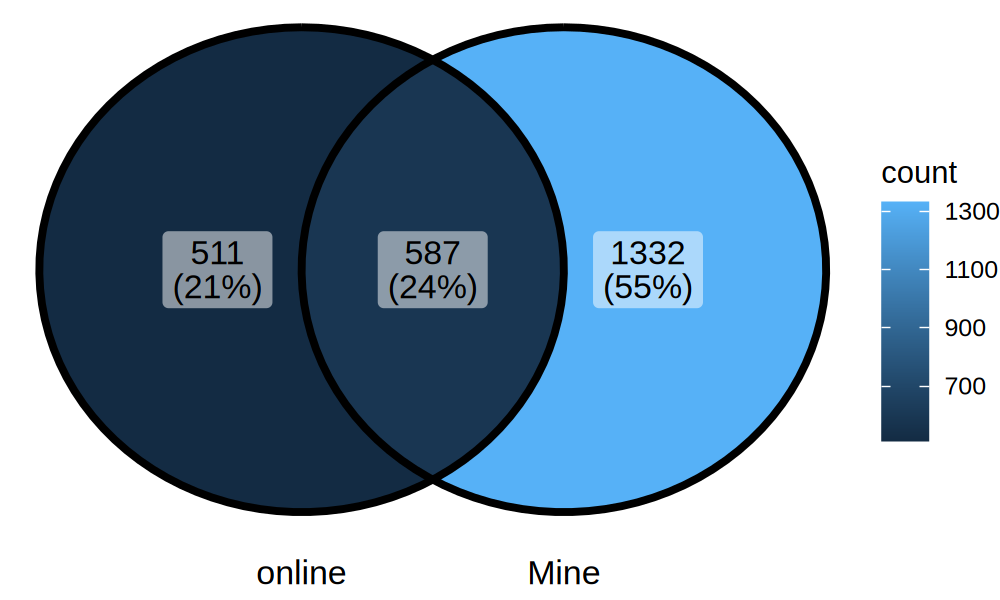

In [30]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
gene_sel = unique(deg_coding_dt[FDR < 0.1 & logFC > 0, rn])
ggVennDiagram(list(online = st_4$External_gene_id, Mine = gene_sel)) + coord_flip() 


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


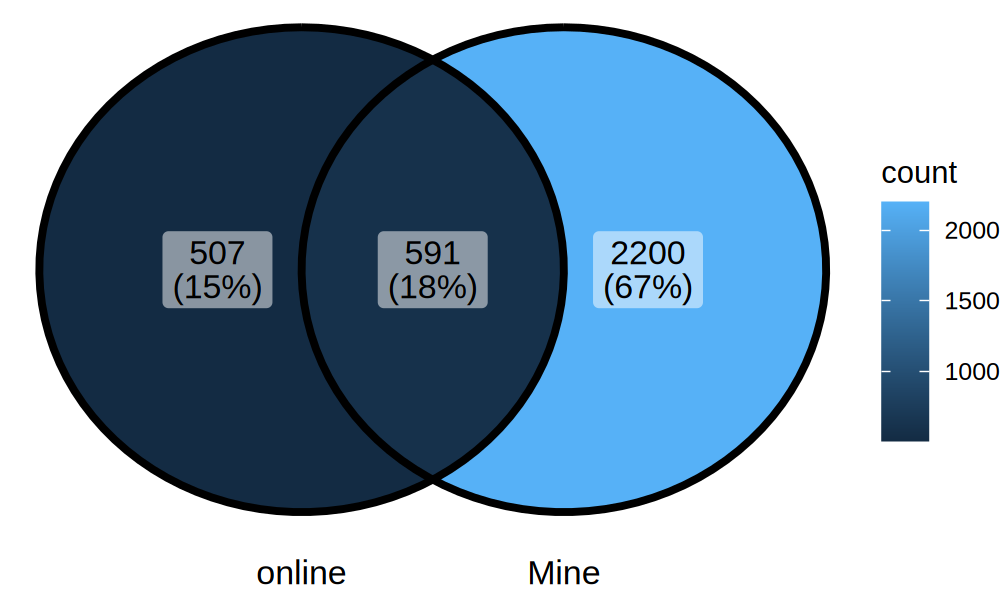

In [31]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
gene_sel = unique(deg_coding_dt[FDR < 0.1, rn])
ggVennDiagram(list(online = st_4$External_gene_id, Mine = gene_sel)) + coord_flip() 


### based on the sig genes from this analysis


CLP CMP  EB GMP HSC MEP  MK MPP 
 20  20  20  20  20  20  20  20 

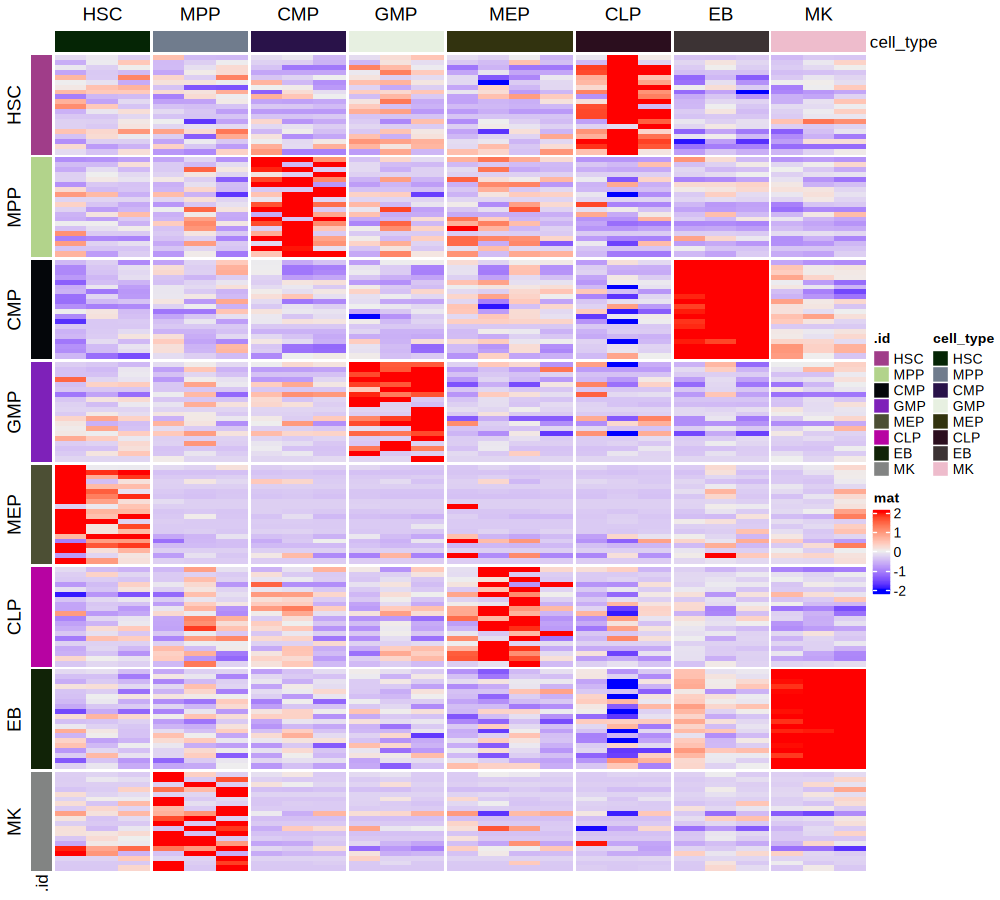

In [37]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
row_sel_list = lapply(cell_types, function (cc) {
    tmp1 = deg_coding_dt[.id == cc, ][logFC > 0, ][order(PValue), ][1:20, ]
    tmp1
})
row_sel = rbindlist(row_sel_list)
table(row_sel$.id)

row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]

plotdat = logcpm_coding[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F, row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  



 CLP  CMP   EB  GMP  HSC  MPP 
   1 1226  837    1  854   12 

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



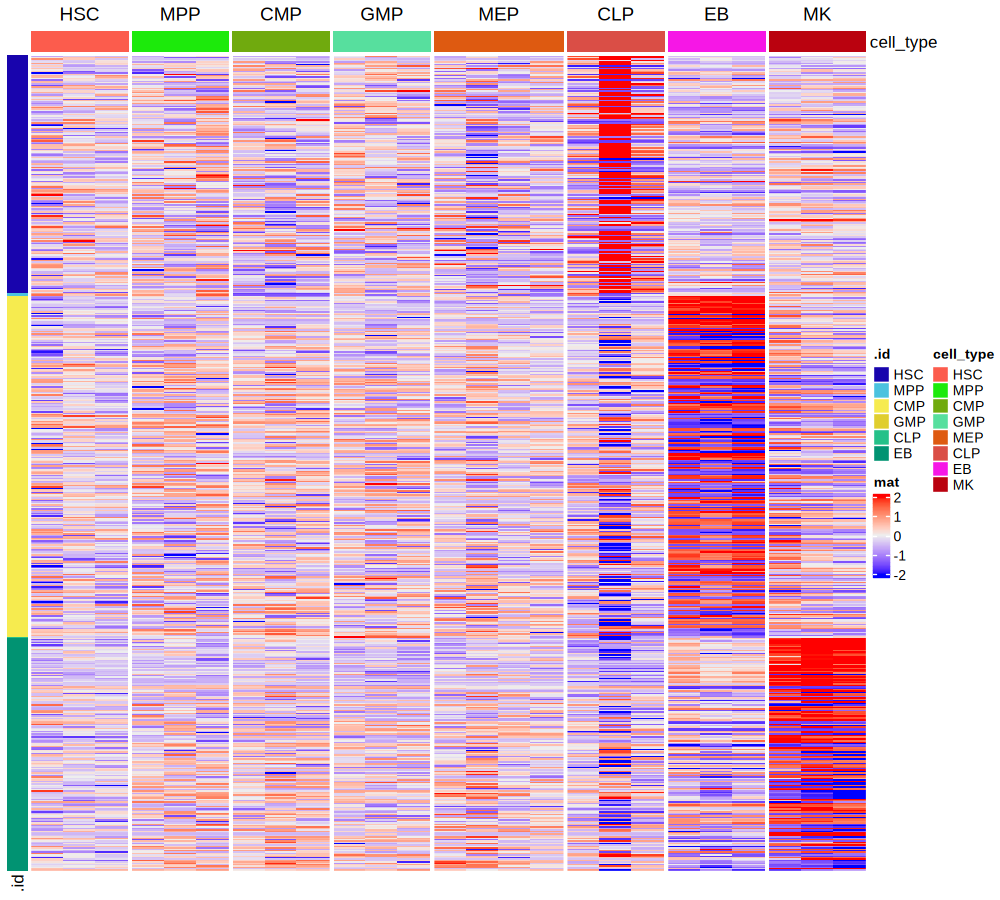

In [34]:
# sig up-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
row_sel_list = lapply(cell_types, function (cc) {
    tmp1 = deg_coding_dt[.id == cc, ][abs(logFC) > 1 & FDR < 0.1, ]
    tmp1
})
row_sel = rbindlist(row_sel_list)
table(row_sel$.id)

row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]

plotdat = logcpm_coding[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  



CLP CMP  EB GMP HSC MEP  MK MPP 
 20  20  20  20  20  20  20  20 

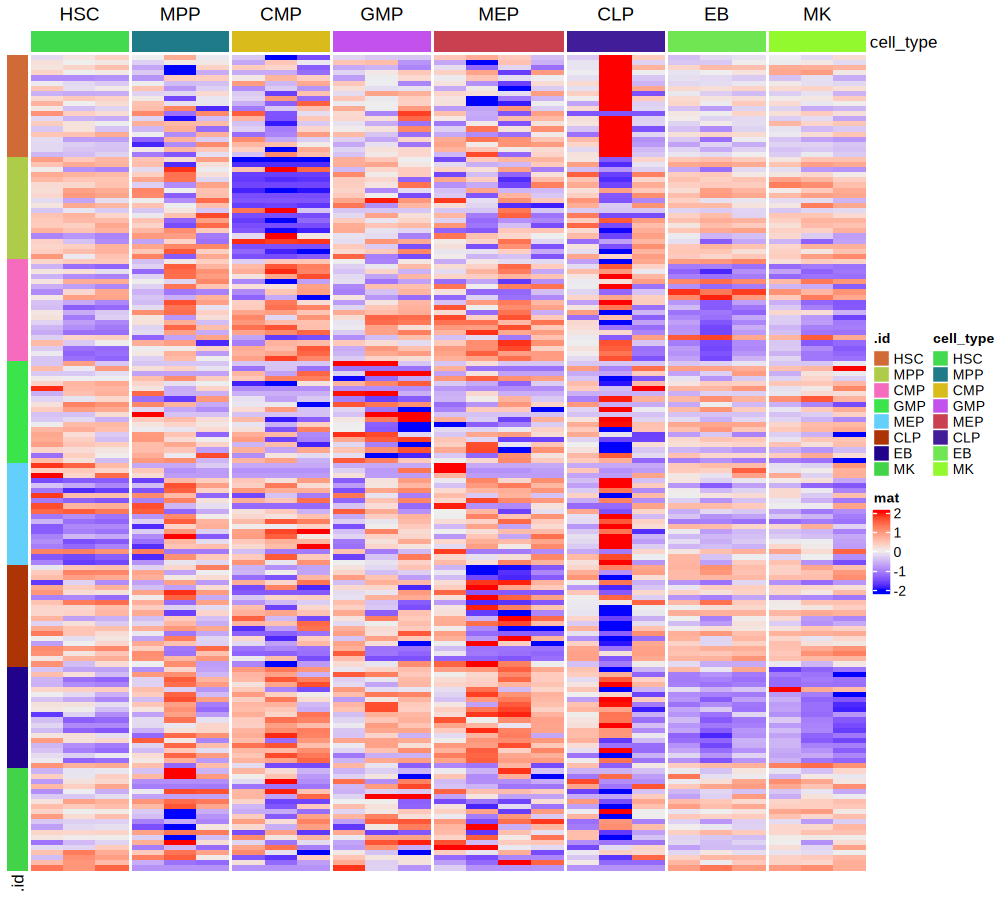

In [213]:
# top 20 up-regulated TE genes for each cell type

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
row_sel_list = lapply(cell_types, function (cc) {
    tmp1 = deg_te_dt[rn %in% rownames(logcpm_te), ][.id == cc, ][order(PValue), ][1:20, ]
    tmp1
})
row_sel = rbindlist(row_sel_list)
table(row_sel$.id)

row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  



CLP HSC MPP 
  7  45  63 

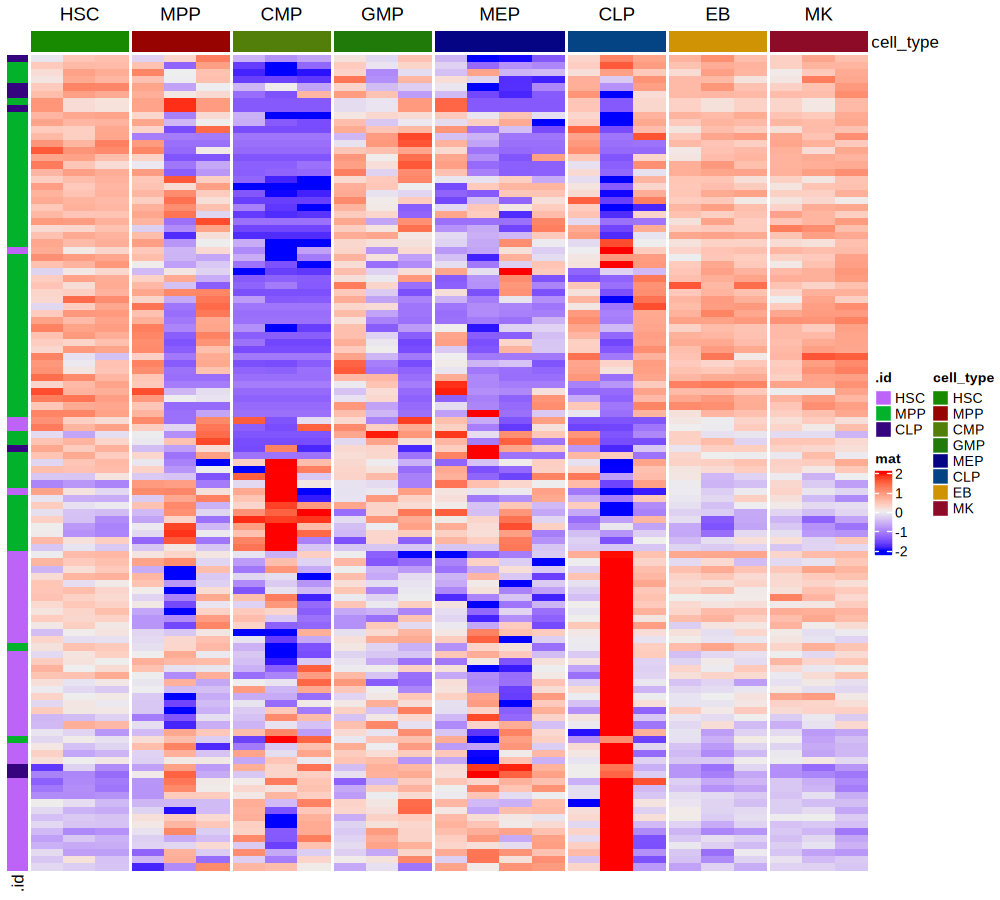

In [214]:
# sig up-regulated te genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
row_sel_list = lapply(cell_types, function (cc) {
    tmp1 = deg_te_dt[.id == cc, ][abs(logFC) > 1 & FDR < 0.1, ]
    tmp1
})
row_sel = rbindlist(row_sel_list)
table(row_sel$.id)

row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = T,
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


# DEG: comparing individual cell types

## all genes

In [36]:
deg_both_list = list()
for(ii in 1:(length(cell_types) - 1)) {
    for(jj in 2:length(cell_types)){
        ii_ctype = cell_types[ii]
        jj_ctype = cell_types[jj]
        if(ii_ctype == jj_ctype) next 
        ii_sample_names = dsn_all[cell_type == ii_ctype, rn]
        jj_sample_names = dsn_all[cell_type == jj_ctype, rn]
        mtx_sel = mtx_all_df[, c(ii_sample_names, jj_sample_names)] 
        ctypes = c(ii_ctype, jj_ctype)
        subtype = factor(c(rep(ii_ctype, length(ii_sample_names)), rep(jj_ctype, length(jj_sample_names))), levels = c(ii_ctype, jj_ctype))
        dge = DGEList(counts = mtx_sel, group = subtype)
        dge <- calcNormFactors(dge)
        keep = filterByExpr(dge)
        dge = dge[keep, , keep.lib.sizes=FALSE]
        dge = normLibSizes(dge)
        design = model.matrix( ~ 0 + subtype)
        dge = estimateDisp(dge, design)
        et <- exactTest(dge)
        deg = topTags(et, n = length(keep))
        deg = as.data.table(deg$table, keep.rownames = T)
        deg$comparison = paste0(ctypes, collapse = '_')
        deg_list = c(deg_list, list(deg))
    }
}

deg_both_dt = rbindlist(deg_both_list) 
head(deg_both_dt)


## DEG: coding genes

In [46]:
deg_coding_list = list()
for(ii in 1:(length(cell_types) - 1)) {
    for(jj in 2:length(cell_types)){
        ii_ctype = cell_types[ii]
        jj_ctype = cell_types[jj]
        if(ii_ctype == jj_ctype) next 
        ii_sample_names = dsn_all[cell_type == ii_ctype, rn]
        jj_sample_names = dsn_all[cell_type == jj_ctype, rn]
        mtx_sel = mtx_coding_df[, c(ii_sample_names, jj_sample_names)] 
        ctypes = c(ii_ctype, jj_ctype)
        subtype = factor(c(rep(ii_ctype, length(ii_sample_names)), rep(jj_ctype, length(jj_sample_names))), levels = c(ii_ctype, jj_ctype))
        dge = DGEList(counts = mtx_sel, group = subtype)
        dge <- calcNormFactors(dge)
        keep = filterByExpr(dge)
        dge = dge[keep, , keep.lib.sizes=FALSE]
        dge = normLibSizes(dge)
        design = model.matrix( ~ 0 + subtype)
        dge = estimateDisp(dge, design)
        et <- exactTest(dge)
        deg = topTags(et, n = length(keep))
        deg = as.data.table(deg$table, keep.rownames = T)
        deg$comparison = paste0(ctypes, collapse = '_')
        deg_list = c(deg_list, list(deg))
    }
}

deg_coding_dt = rbindlist(deg_coding_list) 
head(deg_coding_dt)


<0 x 0 matrix>

## DEG: TE genes

In [47]:
deg_te_list = list()
for(ii in 1:(length(cell_types) - 1)) {
    for(jj in 2:length(cell_types)){
        ii_ctype = cell_types[ii]
        jj_ctype = cell_types[jj]
        if(ii_ctype == jj_ctype) next 
        ii_sample_names = dsn_all[cell_type == ii_ctype, rn]
        jj_sample_names = dsn_all[cell_type == jj_ctype, rn]
        mtx_sel = mtx_all_df[, c(ii_sample_names, jj_sample_names)] 
        ctypes = c(ii_ctype, jj_ctype)
        subtype = factor(c(rep(ii_ctype, length(ii_sample_names)), rep(jj_ctype, length(jj_sample_names))), levels = c(ii_ctype, jj_ctype))
        dge = DGEList(counts = mtx_sel, group = subtype)
        dge <- calcNormFactors(dge)
        keep = filterByExpr(dge)
        dge = dge[keep, , keep.lib.sizes=FALSE]
        dge = normLibSizes(dge)
        design = model.matrix( ~ 0 + subtype)
        dge = estimateDisp(dge, design)
        et <- exactTest(dge)
        deg = topTags(et, n = length(keep))
        deg = as.data.table(deg$table, keep.rownames = T)
        deg$comparison = paste0(ctypes, collapse = '_')
        deg_list = c(deg_list, list(deg))
    }
}

deg_te_dt = rbindlist(deg_te_list) 
head(deg_te_dt)


<0 x 0 matrix>

# identify sig genes for each statistical model

In [59]:
top_gene = 1000

In [62]:
# HSC specific: up-regulated in HSC vs MPP
HSC = deg_dt[comparison == 'HSC_MPP' & logFC < 0, ][order(PValue), ][1:top_gene, ]
# MPP specific: up in MPP vs HSC, dn in MPP vs CLP, and dn in MPP vs CMP
MPP_cond1 = deg_dt[comparison == 'HSC_MPP' & logFC > 0, ][order(PValue), ][1:top_gene, ]
MPP_cond2 = deg_dt[comparison == 'MPP_CMP' & logFC < 0, ][order(PValue), ][1:top_gene, ]
MPP_cond3 = deg_dt[comparison == 'MPP_CLP' & logFC < 0, ][order(PValue), ][1:top_gene, ]
MPP = rbindlist(list(MPP_cond1, MPP_cond2, MPP_cond3)) %>% group_by(rn) %>% filter(n() == 3)
# CLP specific: up in CLP vs MPP
CLP = deg_dt[comparison == 'MPP_CLP' & logFC > 0, ][order(PValue), ][1:top_gene, ]
# CMP specific: up in CMP vs MPP, dn in CMP vs GMP, and dn in CMP vs MEP
CMP_cond1 = deg_dt[comparison == 'MPP_CMP' & logFC > 0, ][order(PValue), ][1:top_gene, ] 
CMP_cond2 = deg_dt[comparison == 'CMP_GMP' & logFC < 0, ][order(PValue), ][1:top_gene, ] 
CMP_cond3 = deg_dt[comparison == 'CMP_MEP' & logFC < 0, ][order(PValue), ][1:top_gene, ] 
CMP = rbindlist(list(CMP_cond1, CMP_cond2, CMP_cond3)) %>% group_by(rn) %>% filter(n() == 3)
# GMP specific: up in GMP vs CMP, 
GMP = deg_dt[comparison == 'CMP_GMP' & logFC > 0, ][order(PValue), ][1:top_gene, ] 
# MEP specific: up in MEP vs GMP, dn in MEP vs EB, and dn in MEP vs MK
MEP_cond1 = deg_dt[comparison == 'CMP_MEP' & logFC > 0, ][order(PValue), ][1:top_gene, ] 
MEP_cond2 = deg_dt[comparison == 'MEP_EB' & logFC < 0, ][order(PValue), ][1:top_gene, ] 
MEP_cond3 = deg_dt[comparison == 'MEP_MK' & logFC < 0, ][order(PValue), ][1:top_gene, ] 
MEP = rbindlist(list(MEP_cond1, MEP_cond2, MEP_cond3)) %>% group_by(rn) %>% filter(n() == 3)
# EB specific: up in EB vs MEP
EB = deg_dt[comparison == 'MEP_EB' & logFC > 0, ][order(PValue), ][1:top_gene, ] 
# MK specific: up in MK vs MEP
MK = deg_dt[comparison == 'MEP_MK' & logFC > 0, ][order(PValue), ][1:top_gene, ] 


In [74]:
hema_list = list(HSC, MPP, CLP, CMP, MEP, GMP, EB, MK)
names(hema_list) = cell_types
hema_dt = as.data.table(rbindlist(hema_list, idcol = T)  %>% group_by(rn) %>% filter(n() == 1) )
hema_dt[, model := factor(.id, levels = cell_types)]
hema_df = setDF(hema_dt, rownames = hema_dt$rn) 
dim(hema_dt)
head(hema_dt)


[1] 3937    8

,.id,rn,logFC,logCPM,PValue,FDR,comparison,model
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
NBEAP2,HSC,NBEAP2,-9.462484,1.900886,1.971293e-07,0.001560887,HSC_MPP,HSC
LOC107986275,HSC,LOC107986275,-12.197614,1.461118,8.978124e-07,0.002302986,HSC_MPP,HSC
LOC124906006,HSC,LOC124906006,-12.183757,1.447287,9.682877e-07,0.002302986,HSC_MPP,HSC
GPR137C,HSC,GPR137C,-8.744987,2.351018,1.401258e-06,0.003012812,HSC_MPP,HSC
LOC100421548,HSC,LOC100421548,-12.157016,1.420856,1.622460e-06,0.003088566,HSC_MPP,HSC
LOC107986103,HSC,LOC107986103,-10.054877,1.594557,1.657490e-06,0.003088566,HSC_MPP,HSC


In [81]:
dim(hema_df)
dim(hema_df[!duplicated(hema_df$rn), ])

[1] 3937    8

[1] 3937    8

In [85]:
table(hema_dt$model)


HSC MPP CMP GMP MEP CLP  EB  MK 
880   0 899   0   0 924 616 618 

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



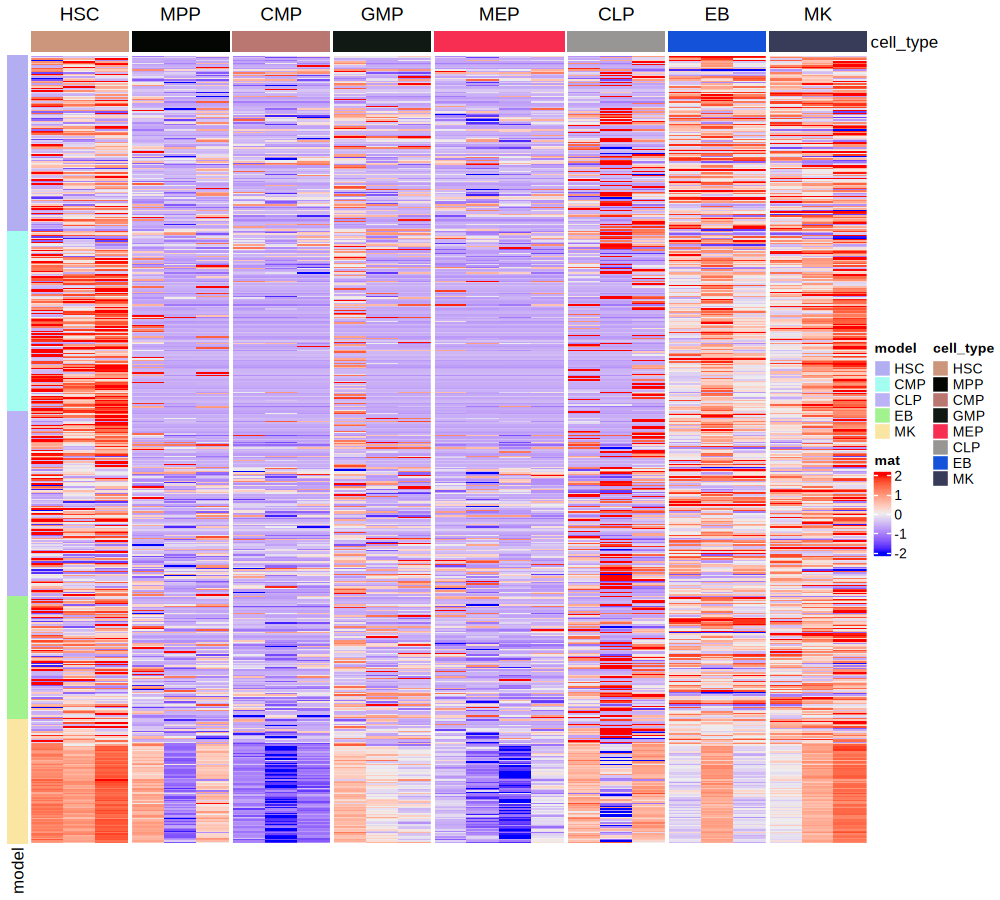

In [83]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

sig_genes = unique(hema_dt$rn)

plotdat = logcpm_all[rownames(logcpm_all) %in% sig_genes, rownames(dsn_all_df)]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = hema_df[, 'model', drop =F]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,  
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


In [ ]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

sig_genes = unique(hema_dt$rn)

st_4_sel = st_4[External_gene_id %in% sig_genes, ]
st_4_sel[, ctype_gene := paste0(Model, '_', External_gene_id)]
st_4_sel[, Model := factor(Model, levels = cell_types)]
st_4_sel = st_4_sel[order(Model), ]

plotdat = logcpm_coding[st_4_sel$External_gene_id, rownames(dsn_all_df)]
rownames(plotdat) = st_4_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = st_4_sel[, .(Model)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,  
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


In [66]:
length(unique(hema_dt$rn)) 

[1] 3937